# Before Getting Started  

このノートブックは、[the Megvii Team](https://github.com/Megvii-BaseDetection)の[YOLOX repository](https://github.com/Megvii-BaseDetection/YOLOX)と[roboflow-ai's notebook](https://colab.research.google.com/drive/1_xkARB35307P0-BTnqMy0flmYrfoYi5T#scrollTo=igwruhYxE_a7)に基づいています。それらのリポジトリを作成して下さったMegviiチームとnotebookを作成して下さったroboflow-aiさんに感謝します。  

This notebook is based on [the Megvii Team](https://github.com/Megvii-BaseDetection)'s [YOLOX repository](https://github.com/Megvii-BaseDetection/ YOLOX) of [the Megvii Team](https://colab.research.google.com/drive/1_xkARB35307P0-BTnqMy0flmYrfoYi5T#scrollTo=igwruhYxE_a7) and [roboflow-ai's notebook](https://colab.research.google.com/drive/1_xkARB35307P0-BTnqMy0flmYrfoYi5T#scrollTo=igwruhYxE_a7). This notebook is based on Thanks to the Megvii team for creating this repository and to roboflow-ai for creating the notebook.

# Mount Google Drive if you need

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Install OpenVINO

In [3]:
!pip install openvino

     |████████████████████████████████| 28.2 MB 47 kB/s 


# Download the model and an image

In [ ]:
!wget https://github.com/yusuke-1105/AI-Bread-Detection/raw/main/yolox-s.onnx
!wget https://github.com/yusuke-1105/AI-Bread-Detection/raw/main/Bread_in.jpg

# Bread Detection

This program detects 5 kinds of breads.  
outputs an image like below.
  
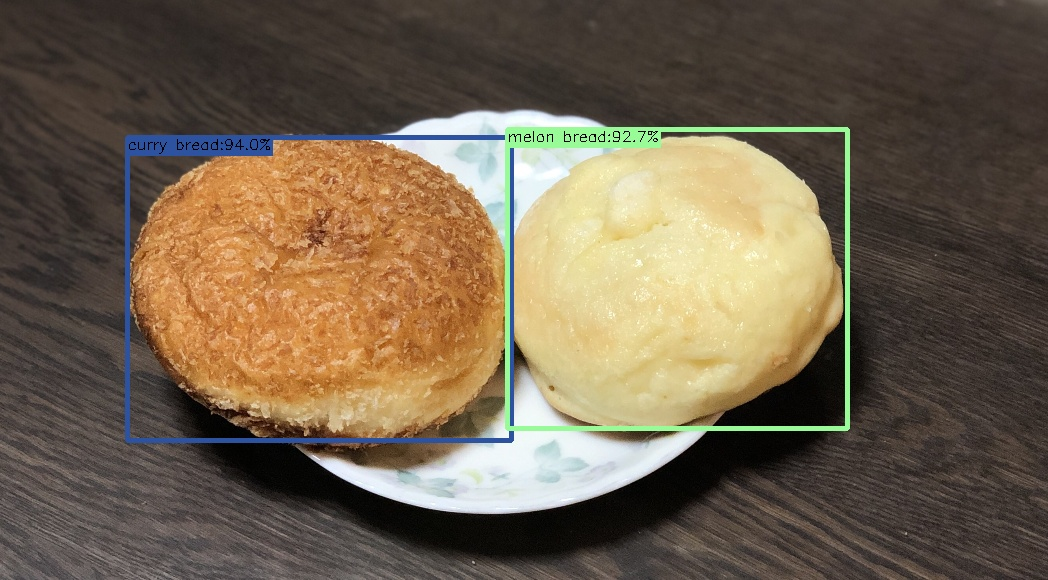

In [9]:
# https://github.com/roboflow-ai/YOLOX を参照して作成
# YOLOX/demo/OpenVINO/python/openvino_inference.pyを主に参照

from openvino.inference_engine import IECore
import logging as log
import numpy as np
import sys
import cv2

# 上記のレポジトリを参照==============================================
def nms(boxes, scores, nms_thr):
    """Single class NMS implemented in Numpy."""
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= nms_thr)[0]
        order = order[inds + 1]

    return keep


def multiclass_nms(boxes, scores, nms_thr, score_thr):
    """Multiclass NMS implemented in Numpy"""
    final_dets = []
    num_classes = scores.shape[1]
    for cls_ind in range(num_classes):
        cls_scores = scores[:, cls_ind]
        valid_score_mask = cls_scores > score_thr
        if valid_score_mask.sum() == 0:
            continue
        else:
            valid_scores = cls_scores[valid_score_mask]
            valid_boxes = boxes[valid_score_mask]
            keep = nms(valid_boxes, valid_scores, nms_thr)
            if len(keep) > 0:
                cls_inds = np.ones((len(keep), 1)) * cls_ind
                dets = np.concatenate(
                    [valid_boxes[keep], valid_scores[keep, None], cls_inds], 1
                )
                final_dets.append(dets)
    if len(final_dets) == 0:
        return None
    return np.concatenate(final_dets, 0)


def demo_postprocess(outputs):

    grids = []
    expanded_strides = []

    strides = [8, 16, 32]
    hsizes = [80, 40, 20]   #hsizes*strides=640
    wsizes = [80, 40, 20]   #wsizes*strides=640

    for hsize, wsize, stride in zip(hsizes, wsizes, strides):
        xv, yv = np.meshgrid(np.arange(wsize), np.arange(hsize))
        grid = np.stack((xv, yv), 2).reshape(1, -1, 2)
        grids.append(grid)
        shape = grid.shape[:2]
        expanded_strides.append(np.full((*shape, 1), stride))

    grids = np.concatenate(grids, 1)
    expanded_strides = np.concatenate(expanded_strides, 1)
    outputs[..., :2] = (outputs[..., :2] + grids) * expanded_strides
    outputs[..., 2:4] = np.exp(outputs[..., 2:4]) * expanded_strides

    return outputs[0]

  
def vis(img, boxes, scores, cls_ids, conf=0.5, class_names=None):

    for i in range(len(boxes)):
        box = boxes[i]
        cls_id = int(cls_ids[i])
        score = scores[i]
        if score < conf:
            continue
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])

        text = '{}:{:.1f}%'.format(class_names[cls_id]['obj'], score * 100)
        txt_color = (0, 0, 0) if np.mean(class_names[cls_id]['color']) > 0.5 else (255, 255, 255)
        font = cv2.FONT_HERSHEY_SIMPLEX

        txt_size = cv2.getTextSize(text, font, 0.5,1)[0]
        cv2.rectangle(img, (x0, y0), (x1, y1),class_names[cls_id]['color'], 4)

        cv2.rectangle(
            img,
            (x0, y0 + 1),
            (x0 + txt_size[0] + 1, y0 + int(1.5*txt_size[1])),
            class_names[cls_id]['color'],
            -1
        )
        cv2.putText(img, text, (x0, y0 + txt_size[1]), font, 0.5, txt_color, thickness=1)

    return img


# ==================================================================


def preproc(img):
    h, w, _ = img.shape

    # 640×640のグレーの無地画像を作成
    padded_img = np.ones((640, 640, 3)) * 114.0

    #画像が640×640に収まるような倍率を計算
    r = min(640 / h, 640 / w)

    #640×640に収まる時の辺の長さを導出
    res_h, res_w = int(h * r), int(w * r)

    # リサイズ
    resized_img = cv2.resize(img, (res_w, res_h), interpolation=cv2.INTER_LINEAR)
    resized_img = resized_img.astype(np.float32)

    # 無地画像にリサイズした後の画像をペースト
    padded_img[: res_h, : res_w] = resized_img

     #BGR -> RGB
    padded_img = padded_img[:, :, ::-1]
    #正規化
    padded_img /= 255.0
    padded_img -= (0.485, 0.456, 0.406)
    padded_img /= (0.229, 0.224, 0.225)

    # hwc > chw
    padded_img = padded_img.transpose((2, 0, 1))
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)

    return padded_img, r

def main(model_path, img_path, output_path):
    
    # 判別するパンの名前と，そのカラー
    COCO_CLASSES = {0: {'obj': "malitozzo", 'color': [255, 245, 0]},
                                  1: {'obj': "curry bread", 'color': [160, 82, 45]},
                                  2: {'obj': "hot dog", 'color': [71, 99, 255]},
                                  3: {'obj': "krone", 'color': [205, 92, 92]},
                                  4: {'obj': "melon bread", 'color': [152, 251, 152]}}

    ie = IECore()   #IECoreをロード
    
    net = ie.read_network(model=model_path)

    input_blob = 'images'
    out_blob = 'output'

    # 出力の精度を決定
    net.input_info[input_blob].precision = 'FP32'
    net.outputs[out_blob].precision = 'FP32'

    # モデルによって識別されるクラスの数
    class_num = max(net.outputs[out_blob].shape)

    # モデルのロード
    exec_net = ie.load_network(network=net, device_name='CPU')

    # 画像の読み込み＆リサイズ
    origin_img = cv2.imread(img_path)
    mag=1048/max(origin_img.shape[0], origin_img.shape[1])
    origin_img=cv2.resize(origin_img, fx=mag, fy=mag, dsize=None)

    # 処理用画像の作成
    image, ratio = preproc(origin_img)

    # 推論開始
    res = exec_net.infer(inputs={input_blob: image})

    # 推論結果
    res = res[out_blob]
    predictions = demo_postprocess(res)

    # オブジェクトの座標の導出-----------------------------------------------------------------
    boxes = predictions[:, :4] 
    scores = predictions[:, 4, None] * predictions[:, 5:]

    boxes_xyxy = np.ones_like(boxes)
    boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2]/2.
    boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3]/2.
    boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2]/2.
    boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3]/2.
    boxes_xyxy /= ratio

    dets = multiclass_nms(boxes_xyxy, scores, nms_thr=0.1, score_thr=0.5)

    # 導出した座標を元に画像にボックスを描画------------------------------------------------
    if dets is not None:
        final_boxes = dets[:, :4]
        final_scores, final_cls_inds = dets[:, 4], dets[:, 5]
        origin_img = vis(origin_img, final_boxes, final_scores, final_cls_inds,
                         conf=0.3, class_names=COCO_CLASSES)

    # -----------------------------------------------------------------------------------------------------


    cv2.imwrite(output_path, origin_img)    # 画像を保存


if __name__ == '__main__':

    # モデル，画像，出力画像のディレクトリを指定---------------------------
    model_path = 'yolox-s.onnx'
    img_path = 'Bread_in.jpg'
    output_path = 'Bread_out.jpg'
    #---------------------------------------------------------------------------------------

    # 推論開始 !
    main(model_path, img_path, output_path)